SET UP DATASET VIA KAGGLE API

In [6]:
!pip install kaggle

In [7]:
from google.colab import files

# Upload the Kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d shanegerami/ai-vs-human-text

ai-vs-human-text.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
!unzip ai-vs-human-text.zip

Archive:  ai-vs-human-text.zip
replace AI_Human.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

SET UP THE ENVIRONNEMENT

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
dataset = pd.read_csv("/content/AI_Human.csv")
dataset.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [13]:
dataset.tail()

,text,generated
487230,Tie Face on Mars is really just a big misunder...,0.0
487231,The whole purpose of democracy is to create a ...,0.0
487232,I firmly believe that governments worldwide sh...,1.0
487233,I DFN't agree with this decision because a LFT...,0.0
487234,"Richard Non, Jimmy Carter, and Bob Dole and ot...",0.0


-*Observation*:
we could observe that the dataset is shuffle.

In [14]:
dataset[dataset["generated"] == 1].count()

text         181438
generated    181438
dtype: int64

In [15]:
dataset[dataset["generated"] == 0].count()

text         305797
generated    305797
dtype: int64

-*Observation*:

There is double data that are generated by human than AI.

I think that because of this that the system can be biased.

In [16]:
dataset['length'] = dataset['text'].apply(len)

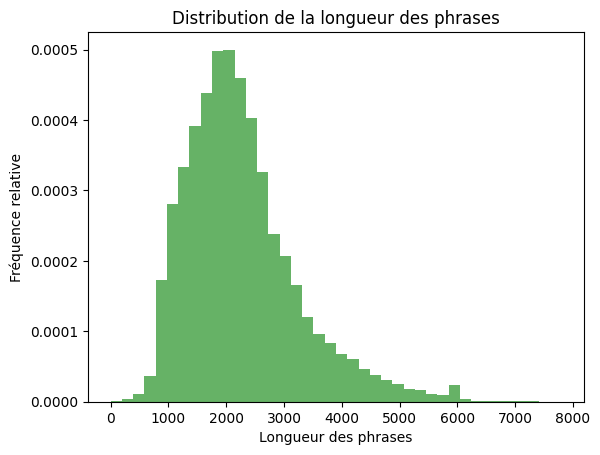

In [17]:
plt.hist(dataset['length'], bins=40, density=True, alpha=0.6, color='g',  range=(0, 7800))


plt.title('Distribution de la longueur des phrases')
plt.xlabel('Longueur des phrases')
plt.ylabel('Fréquence relative')
plt.show()

In [18]:
length_counts = dataset["length"].value_counts()
print(length_counts)


1974    320
1942    303
2082    303
1855    302
2048    296
       ... 
555       1
8436      1
5236      1
6117      1
6320      1
Name: length, Length: 6419, dtype: int64


-Observation:

I think that i will limited the AI model to 1974 words. Rectification i don't have enough ressources for runninig up to 1974 words.

In [44]:
dataset.count()

text         487235
generated    487235
length       487235
dtype: int64

In [45]:
dataset_human = dataset[dataset['generated']==0]
dataset_ai = dataset[dataset['generated']==1]

In [46]:
limit_text = 60000
percentage_text = int(60000*70/100)

In [47]:
from sklearn.utils import shuffle


x_human = shuffle(dataset_human["text"][0:limit_text], random_state= 42)
x_ai = shuffle(dataset_ai["text"][0:limit_text], random_state= 42)
y_human = shuffle(dataset_human["generated"][0:limit_text], random_state = 42)
y_ai = shuffle(dataset_ai["generated"][0:limit_text], random_state = 42)

In [48]:
y_ai.head()

28723    1.0
76203    1.0
79914    1.0
24620    1.0
24374    1.0
Name: generated, dtype: float64

In [49]:
y_human.head()

13664    0.0
70679    0.0
81138    0.0
9561     0.0
9315     0.0
Name: generated, dtype: float64

In [50]:
x_human.count()

60000

In [51]:
x_ai.count()

60000

In [52]:


x_train = pd.concat([x_human[0:percentage_text],x_ai[0:percentage_text]], ignore_index = True)
x_test = pd.concat([x_human[percentage_text:],x_ai[percentage_text:]], ignore_index = True)
y_train = pd.concat([y_human[0:percentage_text],y_ai[0:percentage_text]], ignore_index = True)
y_test = pd.concat([y_human[percentage_text:],y_ai[percentage_text:]], ignore_index = True)

random_seed = 42


combined_data_train = pd.concat([x_train, y_train], axis=1)
combined_data_test = pd.concat([x_test,y_test], axis = 1)

# Shuffle the combined DataFrame
shuffled_data_train = shuffle(combined_data_train, random_state=random_seed)
shuffled_data_test = shuffle(combined_data_test, random_state=random_seed)

# Splitting into training and testing sets
x_train = shuffled_data_train["text"]
y_train = shuffled_data_train["generated"]
x_test = shuffled_data_test["text"]
y_test = shuffled_data_test["generated"]

In [53]:
y_train.value_counts()

0.0    42000
1.0    42000
Name: generated, dtype: int64

In [54]:
y_test.value_counts()

0.0    18000
1.0    18000
Name: generated, dtype: int64


vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = ""
training_size = 20000

In [55]:
#parameters
max_len_words = 1000
nums_words = 10000

In [56]:
tokenizer = Tokenizer(num_words=nums_words, oov_token = "<OOV>")
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

In [57]:
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences, maxlen = max_len_words,
                                padding = "post", truncating = "post")
test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = pad_sequences(test_sequences, maxlen = max_len_words,
                                padding = "post", truncating = "post")

In [58]:
print(test_padded)

[[ 60  27  83 ...   0   0   0]
 [115  41  15 ...   0   0   0]
 [ 20 118   8 ...   0   0   0]
 ...
 [ 45   9   2 ...   0   0   0]
 [ 88   6 100 ...   0   0   0]
 [ 20 602  83 ...   0   0   0]]


In [60]:
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

#reset

optimizer = Adam(learning_rate=0.0005)
model = 0
# Définir les paramètres pour overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
num_epochs = 30

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(nums_words, 32, input_length = max_len_words),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation="relu", ),

    tf.keras.layers.Dense(1,activation = "sigmoid")
])


model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics = ["accuracy"])

training_padded = np.array(training_padded)
training_labels = np.array(y_train)
testing_padded = np.array(test_padded)
testing_labels = np.array(y_test)

history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    batch_size = 16,
                    validation_data=(testing_padded, testing_labels),
                    callbacks=[early_stopping], verbose=2)

Epoch 1/30
5250/5250 - 52s - loss: 0.3684 - accuracy: 0.9159 - val_loss: 0.1201 - val_accuracy: 0.9854 - 52s/epoch - 10ms/step
Epoch 2/30
5250/5250 - 52s - loss: 0.1236 - accuracy: 0.9807 - val_loss: 0.0797 - val_accuracy: 0.9895 - 52s/epoch - 10ms/step
Epoch 3/30
5250/5250 - 49s - loss: 0.0908 - accuracy: 0.9857 - val_loss: 0.0653 - val_accuracy: 0.9903 - 49s/epoch - 9ms/step
Epoch 4/30
5250/5250 - 49s - loss: 0.0764 - accuracy: 0.9876 - val_loss: 0.0580 - val_accuracy: 0.9919 - 49s/epoch - 9ms/step
Epoch 5/30
5250/5250 - 48s - loss: 0.0666 - accuracy: 0.9898 - val_loss: 0.0467 - val_accuracy: 0.9939 - 48s/epoch - 9ms/step
Epoch 6/30
5250/5250 - 48s - loss: 0.0610 - accuracy: 0.9902 - val_loss: 0.0438 - val_accuracy: 0.9948 - 48s/epoch - 9ms/step
Epoch 7/30
5250/5250 - 49s - loss: 0.0558 - accuracy: 0.9913 - val_loss: 0.0485 - val_accuracy: 0.9930 - 49s/epoch - 9ms/step
Epoch 8/30
5250/5250 - 52s - loss: 0.0520 - accuracy: 0.9917 - val_loss: 0.0406 - val_accuracy: 0.9948 - 52s/epoch -

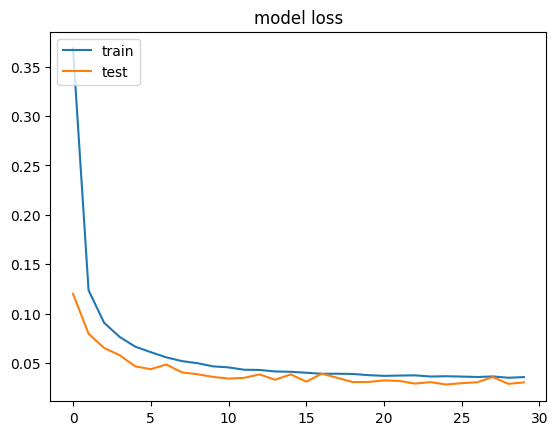

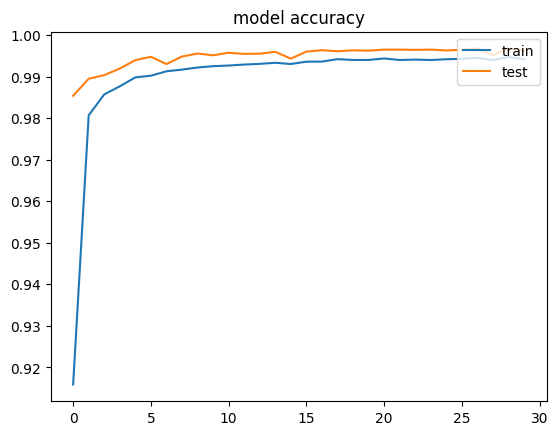

In [61]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train", "test"], loc="upper left")
plt.title("model loss")
plt.show()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["train", "test"], loc="upper right")
plt.title("model accuracy")
plt.show()


In [66]:
x_human_test = dataset_human["text"][140000:160000]
x_ai_test = dataset_ai["text"][140000:140000]
y_human_test = dataset_human["generated"][140000:160000]
y_ai_test = dataset_ai["generated"][140000:160000]

In [67]:
x_human_test.head()

229673    The principle has decided that it would be a g...
229675    When are parents gave us advice we are able to...
229676    To think that scientists have been able to pro...
229678    Everyday proper Dir in car accidents because t...
229679    The natural face\n\nI thing the face is a natu...
Name: text, dtype: object

In [68]:
y_human_test.head()

229673    0.0
229675    0.0
229676    0.0
229678    0.0
229679    0.0
Name: generated, dtype: float64

In [69]:
# Concatenate and shuffle the test set
x_test = pd.concat([x_human_test, x_ai_test], ignore_index=True)
y_test = pd.concat([y_human_test, y_ai_test], ignore_index=True)

combined_data_test = pd.concat([x_test, y_test], axis=1)

# Shuffle the combined DataFrame
shuffled_data_test = shuffle(combined_data_test, random_state=random_seed)

# Reset index to ensure that column titles are preserved
shuffled_data_test.reset_index(drop=True, inplace=True)

x_shuffled_test = shuffled_data_test.iloc[:, 0]
y_shuffled_test = shuffled_data_test.iloc[:, 1]

# Tokenize and pad the test data
sequences_test = tokenizer.texts_to_sequences(x_shuffled_test.astype("str"))
padded_test = pad_sequences(sequences_test, maxlen=max_len_words, padding="post", truncating="post")

# Evaluate the model on the test set
loss, accuracy = model.evaluate(padded_test, y_shuffled_test)

# Print the results
print("Loss:", loss)
print("Accuracy:", accuracy)


1250/1250 [==============================] - 8s 6ms/step - loss: 0.0242 - accuracy: 0.9979
Loss: 0.024192137643694878
Accuracy: 0.9978749752044678
